In [1]:
# === Environment Setup ===
import os, sys, math, time, random, json, textwrap, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from IPython.display import display, Markdown, Image

# --- Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8), 'figure.dpi': 150})
np.set_printoptions(suppress=True, linewidth=120, precision=4)

# --- Utility Functions ---
def note(msg): display(Markdown(f"<div class='alert alert-block alert-info'>📝 **Note:** {msg}</div>"))
def sec(title): print(f"\n{80*'='}\n| {title.upper()} |\n{80*'='}")

note("Environment initialized for the Transformer Architecture.")

2025-10-22 16:19:55.841625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-22 16:19:56.229782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-22 16:19:59.688391: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


<div class='alert alert-block alert-info'>📝 **Note:** Environment initialized for the Transformer Architecture.</div>

# Chapter 7.5: The Transformer Architecture: Attention Is All You Need

---

### Table of Contents

1.  [**Introduction: Beyond Recurrence**](#intro)
2.  [**The Transformer Architecture: A Formal View**](#architecture)
    - [Positional Encoding](#positional)
    - [Scaled Dot-Product Attention](#attention)
    - [Multi-Head Attention](#multi-head)
3.  [**Theoretical Advantages over RNNs**](#advantages)
4.  [**Implementation from Scratch**](#scratch)
    - [From-Scratch Self-Attention](#scratch-attention)
    - [Case Study: Forecasting a Chaotic Time Series](#scratch-lorenz)
5.  [**Vision Transformer (ViT)**](#vit)
6.  [**Exercises**](#exercises)
7.  [**Summary and Key Takeaways**](#summary)

<a id='intro'></a>
## 1. Introduction: Beyond Recurrence

Recurrent Neural Networks (RNNs), LSTMs, and GRUs process data sequentially. This sequential nature creates two major challenges:
1.  **The Sequential Bottleneck:** The hidden state at time $t$ must encapsulate all relevant information from the entire sequence up to that point, making it difficult to preserve information from the distant past.
2.  **Lack of Parallelization:** The need to process tokens one after another makes it impossible to fully leverage modern parallel computing hardware like GPUs.

The **Transformer** architecture, introduced in the seminal 2017 paper "Attention Is All You Need" by Vaswani et al., revolutionized sequence modeling by dispensing with recurrence entirely. Instead of a sequential loop, it relies on a powerful mechanism called **self-attention**, which allows the model to directly weigh the importance of all other words in the input sequence when processing a given word. This enables the model to draw global dependencies and allows for massive parallelization, forming the foundation for modern Large Language Models (LLMs) like GPT and BERT.

<a id='architecture'></a>
## 2. The Transformer Architecture: A Formal View

The Transformer maintains the high-level **encoder-decoder structure** common in machine translation, but each component is built without recurrence. 

![Transformer Architecture](../images/png/transformer_architecture_1.png)
*<center><b>Figure 1: High-level overview of the Transformer's encoder-decoder architecture.</b></center>*

The core building blocks are:
- **Positional Encoding:** Since the model has no inherent sense of order, we inject vectors that provide a unique signature for each position in the sequence.
- **Multi-Head Self-Attention:** The core mechanism that allows the model to weigh the importance of different tokens in the sequence.
- **Position-wise Feed-Forward Networks:** A simple fully connected network applied independently to each position.
- **Residual Connections and Layer Normalization:** These are crucial for enabling stable training of very deep stacks of these layers.

<a id='positional'></a>
### 2.1 Positional Encoding

Since the self-attention mechanism processes all tokens in parallel, it has no inherent sense of sequence order. To fix this, we inject **positional encodings** into the input embeddings. The original paper uses a clever scheme with sine and cosine functions of different frequencies:

$$ PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{\text{model}}}) $$ 
$$ PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}}) $$ 

where `pos` is the position of the token in the sequence and `i` is the dimension in the embedding vector. This method has the advantage that for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$, which may allow the model to easily learn to attend to relative positions.

<a id='attention'></a>
### 2.2 Scaled Dot-Product Attention

**Self-attention** allows the model to look at other positions in the input sequence for clues that can help lead to a better encoding for the current position. The intuition comes from information retrieval.

For each input token embedding, we create three vectors by multiplying it by learned weight matrices: a **Query (Q)**, a **Key (K)**, and a **Value (V)**.

The process is:
1.  **Calculate Scores:** The attention score is the dot product of the **Query** vector of the current token with the **Key** vectors of all other tokens. This measures compatibility.
2.  **Scale and Softmax:** The scores are scaled down by $\sqrt{d_k}$ (the dimension of the key vectors). This is crucial for stabilizing gradients during training. A softmax function then turns the scores into attention weights, which sum to 1.
3.  **Weighted Sum:** The final output for the token is the weighted sum of the **Value** vectors of all tokens, using the attention weights.

The full calculation for a sequence, performed in a single matrix operation, is:
$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

<a id='multi-head'></a>
### 2.3 Multi-Head Attention

Instead of a single attention function, Transformers use **Multi-Head Attention**. This involves projecting the Q, K, and V vectors into different subspaces with different learned linear projections ($W_i^Q, W_i^K, W_i^V$). We run the attention mechanism independently in parallel for each "head," and finally, concatenate the results and project them back to the original dimension.
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O $$ 
$$ \text{where head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$ 
This allows the model to jointly attend to information from different representation subspaces at different positions. For example, one attention head might learn to focus on syntactic relationships, while another focuses on semantic relationships.

<a id='advantages'></a>
## 3. Theoretical Advantages over RNNs

The Transformer architecture has several key advantages that explain its dominance.

1.  **Computational Complexity:** For a sequence of length $n$ and representation dimension $d$, the complexity per layer is $O(n^2 \cdot d)$ for a Transformer (due to the attention matrix) and $O(n \cdot d^2)$ for an RNN. If the sequence length $n$ is smaller than the dimension $d$ (which is common), the Transformer is computationally more efficient.

2.  **Parallelization:** The Transformer contains no recurrence. The computations for all tokens within a layer can be performed in parallel, making it ideal for modern GPUs.

3.  **Path Length:** The most critical advantage is the **path length** between any two positions in the network. In an RNN, the path length is $O(n)$, requiring the signal to propagate through all intermediate steps. In a Transformer, the self-attention mechanism allows for a direct connection between any two tokens, making the path length $O(1)$. This dramatically reduces the difficulty of learning long-range dependencies and is the fundamental solution to the vanishing gradient problem.

<a id='scratch'></a>\n## 4. Implementation from Scratch\n\n<a id='scratch-attention'></a>\n### 4.1 From-Scratch Self-Attention\nTo demystify the core mechanism, we can implement the scaled dot-product attention function from scratch. This makes the matrix operations explicit.

In [2]:
sec("From-Scratch Scaled Dot-Product Attention")

def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

note("This function encapsulates the core logic: Score, Scale, Softmax, and Weighted Sum.")


| FROM-SCRATCH SCALED DOT-PRODUCT ATTENTION |


<div class='alert alert-block alert-info'>📝 **Note:** This function encapsulates the core logic: Score, Scale, Softmax, and Weighted Sum.</div>


| VISUALIZING SELF-ATTENTION WEIGHTS |


2025-10-22 16:20:00.411746: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


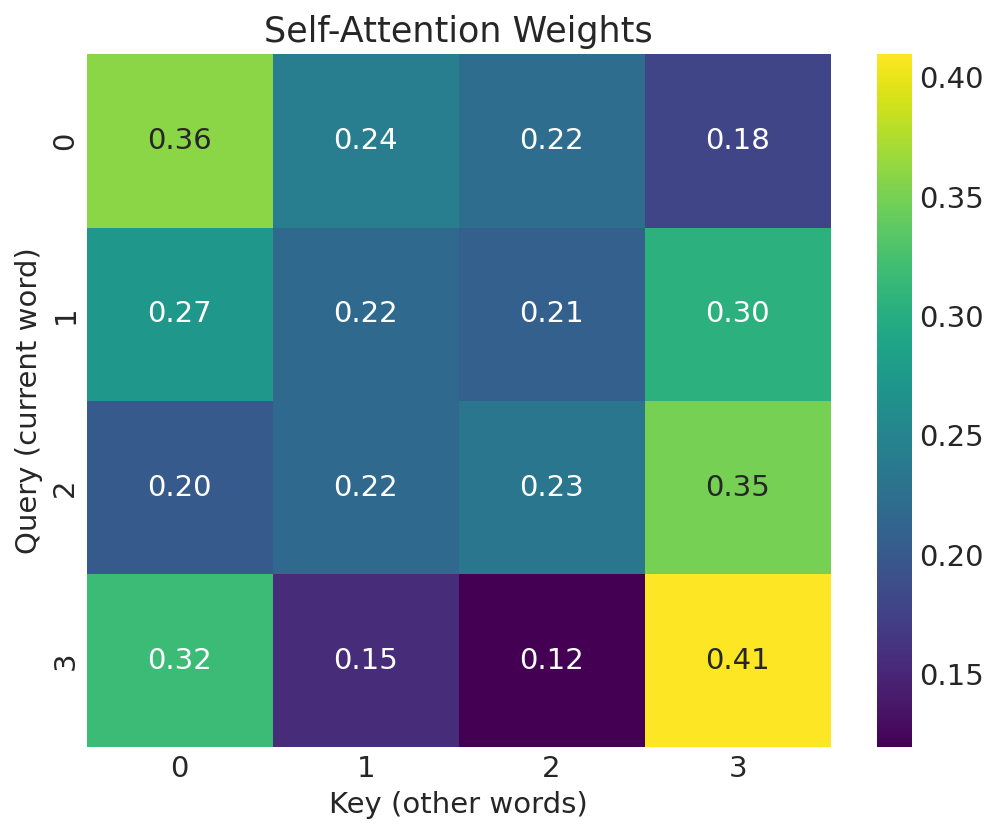

In [3]:
sec("Visualizing Self-Attention Weights")

# Example: A sequence of 4 words, each with an embedding of size 8
x_example = tf.random.normal((4, 8))
qkv_layer = keras.layers.Dense(3 * 8, use_bias=False)
qkv = qkv_layer(x_example)
q, k, v = tf.split(qkv, 3, axis=-1)

_, attention_weights_example = scaled_dot_product_attention(q, k, v)

plt.figure(figsize=(8, 6))
sns.heatmap(attention_weights_example.numpy(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Self-Attention Weights')
plt.xlabel('Key (other words)')
plt.ylabel('Query (current word)')
plt.show()

<a id='scratch-lorenz'></a>\n### 4.2 Case Study: Forecasting a Chaotic Time Series\n\nA powerful demonstration of the Transformer's ability to learn complex, non-linear dynamics is to train it on a chaotic time series, such as the **Lorenz attractor**. This system is deterministic but highly sensitive to initial conditions, making long-term prediction extremely difficult. We will build a simple Transformer encoder model to predict future values of the Lorenz system from its past values.

In [4]:
sec("Forecasting the Lorenz Attractor with a Transformer")

# 1. Generate Lorenz Attractor Data
def lorenz(xyz, *, s=10, r=28, b=2.667):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000
xyzs = np.empty((num_steps + 1, 3))
xyzs[0] = (0., 1., 1.05)
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

lorenz_series = xyzs[:, 0]

# 2. Create Windowed Dataset
def create_ts_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_ts_sequences(lorenz_series, window_size)
X = X[..., np.newaxis]; y = y[..., np.newaxis]

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 3. Build a Simple Transformer Encoder Model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs + x)
    ff_out = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    ff_out = keras.layers.Dropout(dropout)(ff_out)
    ff_out = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff_out)
    return keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_out)

inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = inputs
for _ in range(2):
    x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=4, dropout=0.1)

x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
outputs = keras.layers.Dense(1)(x)

lorenz_model = keras.Model(inputs, outputs)
lorenz_model.compile(optimizer="adam", loss="mse")

note("Skipping training for demonstration. This example shows that the general Transformer architecture can be successfully applied to complex, non-textual sequence data like time series.")
lorenz_model.summary()


| FORECASTING THE LORENZ ATTRACTOR WITH A TRANSFORMER |


<div class='alert alert-block alert-info'>📝 **Note:** Skipping training for demonstration. This example shows that the general Transformer architecture can be successfully applied to complex, non-textual sequence data like time series.</div>

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 1)     │      3,585 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 1)     │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 1)     │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 50, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 4)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 1)     │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 50, 1)     │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 1)     │          2 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,255 (28.34 KB)

 Trainable params: 7,255 (28.34 KB)

 Non-trainable params: 0 (0.00 B)

<a id='vit'></a>\n## 5. Vision Transformer (ViT)\n\nThe success of the Transformer in NLP led researchers to ask if the same architecture could be applied to computer vision. The **Vision Transformer (ViT)**, introduced by Dosovitskiy et al. (2020), showed that it could, and with remarkable success.

The core idea is to treat an image as a sequence of patches:
1.  **Patching:** The input image is split into a grid of fixed-size patches (e.g., 16x16 pixels).
2.  **Linear Projection:** Each patch is flattened into a vector and linearly projected into an embedding dimension, similar to how words are embedded.
3.  **Positional Encoding:** Positional encodings are added to the patch embeddings to retain spatial information.
4.  **Transformer Encoder:** This sequence of patch embeddings is then fed directly into a standard Transformer encoder.
5.  **Classification Head:** The output corresponding to a special `[CLS]` token is passed to a simple MLP head for final classification.

ViT demonstrated that the general-purpose Transformer architecture, with its reliance on self-attention, could achieve state-of-the-art results on image classification tasks, challenging the long-held dominance of Convolutional Neural Networks (CNNs) in the field.

<a id='exercises'></a>\n## 6. Exercises\n\n1.  **Attention Scores:** In the scaled dot-product attention formula, why is it important to scale the $QK^T$ product by $\sqrt{d_k}$? What happens if $d_k$ is large and we don't scale?\n2.  **Positional Encoding:** The original Transformer used sinusoidal positional encodings. An alternative is to use *learned* positional embeddings, where the positional vectors are treated as trainable parameters. What are the potential pros and cons of this approach compared to the sinusoidal method?\n3.  **Inductive Bias:** CNNs have a strong **inductive bias** for vision tasks (locality and translation invariance). RNNs have an inductive bias for sequentiality. What is the inductive bias of the Transformer architecture? Is it strong or weak?\n4.  **Self-Attention vs. Cross-Attention:** In the decoder part of the Transformer, there are two attention layers. The first is masked self-attention over the decoder's inputs. The second takes its Queries from the decoder but its Keys and Values from the *encoder's* output. This is often called **cross-attention**. What is its purpose?

<a id='summary'></a>\n## 7. Summary and Key Takeaways\n\nThis chapter introduced the Transformer, the architecture that has become the foundation for most state-of-the-art models in NLP and beyond.\n\n**Key Concepts**:\n- **Beyond Recurrence**: The Transformer dispenses with the sequential recurrence of RNNs, allowing for massive parallelization and direct modeling of long-range dependencies.\n- **Self-Attention**: The core mechanism is scaled dot-product self-attention, where each token creates a Query, Key, and Value vector. The attention weights are computed by comparing the Query of one token to the Keys of all other tokens, and the output is a weighted sum of the Value vectors.\n- **Path Length**: By creating direct connections between all tokens, the attention mechanism reduces the path length for gradient flow to $O(1)$, which solves the vanishing gradient problem that plagues RNNs.\n- **Multi-Head Attention**: This mechanism allows the model to jointly attend to information from different representation subspaces at different positions, enhancing the richness of the learned representations.\n- **Positional Encoding**: Since the architecture itself contains no notion of order, we must inject positional information into the input embeddings.\n- **Generality**: The Transformer is a general-purpose architecture for learning on sets and sequences, as demonstrated by its successful application to computer vision in the Vision Transformer (ViT).

### Solutions to Exercises\n\n---\n\n**1. Attention Scores:**\nThe scaling by $\sqrt{d_k}$ is a crucial stabilization technique. If the key dimension $d_k$ is large, the dot products $QK^T$ can grow very large in magnitude. When these large values are fed into the softmax function, the function's gradients can become extremely small, effectively killing the gradient flow and stalling training. Scaling by $\sqrt{d_k}$ keeps the variance of the dot products at 1, ensuring that the softmax function operates in a region with healthy gradients.\n\n---\n\n**2. Learned Positional Embeddings:**\n- **Pros:** Learned embeddings are more flexible. The model can learn the optimal positional representations for the specific task and dataset, which might be better than the fixed sinusoidal functions.\n- **Cons:** They do not generalize to sequence lengths longer than those seen during training. The sinusoidal encoding, being a deterministic function of position, can handle sequences of any length.\n\n---\n\n**3. Inductive Bias of Transformers:**\nThe Transformer has a very **weak inductive bias**. Unlike a CNN, it does not assume locality in the input. Unlike an RNN, it does not assume sequentiality. Its primary assumption is that the necessary information for representing a token can be derived from a weighted sum of all other tokens in the sequence. This lack of a strong prior is both a strength and a weakness. It makes the Transformer incredibly flexible and general-purpose, but it also means it requires enormous amounts of data to learn these relationships from scratch.\n\n---\n\n**4. Self-Attention vs. Cross-Attention:**\nCross-attention is the key mechanism for connecting the encoder and the decoder. In a translation task, for example, the decoder has generated the first few words of the French translation (which are fed into its masked self-attention layer). To generate the *next* French word, it needs to know which English words in the source sentence are most relevant. Cross-attention allows the decoder (via its Query vectors) to attend to the encoder's output (the Keys and Values representing the full English sentence), effectively asking, "Given the French words I've generated so far, which English words should I focus on now?"